# Trying out sympy module

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sympy as sp
import numpy as np
from Modules.sympy.classes import *
from Modules.sympy.utils import *
from sympy.physics.quantum import Dagger
from Modules.sympy.solver import *

In [3]:
Spin = RDBasis("\\sigma", 'spin', dim=2)
sx = Spin.project(sp.Matrix([[0, 1], [1, 0]]))
sz = Spin.project(sp.Matrix([[1, 0], [0, -1]]))

a = RDBoson("a", subspace ="b")
ad = RDBoson("{a^\\dagger}", subspace ="b", is_annihilation=False)

hbar = RDsymbol("hbar", order = 0)
omega = RDsymbol("omega", order = 0)
Omega_z = RDsymbol("\\Omega_{z}", order = 0)
g = RDsymbol("g", order = 1)

H = hbar * omega * ad * a + hbar * Omega_z * sp.Rational(1,2) * sz - hbar * g * (a + ad) * sx
H

\Omega_{z}*hbar*\sigma_{3}/2 - g*hbar*(a + {a^\dagger})*\sigma_{1} + hbar*omega*{a^\dagger}*a

In [4]:
from IPython.display import display, Math
def display_dict(d):
    for k, v in d.items():
        display(Math(f"{sp.latex(k)} = {sp.latex(v)}"))

# Better Solver

In [5]:
def generate_keys(order):
    keys = [] # will contain keys
    
    def deapth_first_search(current_key, current_sum):
        if current_sum > order: # if current_sum is bigger than order
            return # return nothing
        if current_key: # if current key is not empty
            keys.append(current_key[:]) # append current key to keys
        start = 0 if not current_key else 1 # if current key is empty, start the next number from 0, else from 1
        for i in range(start, order + 1): # looping over values between start and order
            current_key.append(i) # append current number to the key
            deapth_first_search(current_key, current_sum + i) # recurse down the tree
            current_key.pop() # backtrack

            
            
    deapth_first_search([], 0) # start search with inital sum to zero
    return keys

def custom_sort_key(sublist):
    """
    Custom sorting key function:
    - First, sorts by the sum of sublist elements in increasing order.
    - Second, sorts sublists with equal sums by moving sublists of length 2 containing a 0 in the first element to the bottom.
    """
    sublist_sum = sum(sublist)
    sublist_length = len(sublist)

    if sublist_length == 2 and sublist[0] == 0:
        # Ensure sublists of length 2 with a 0 in the first element go to the bottom
        return (sublist_sum, 1)
    else:
        return (sublist_sum, 0)

def rearrange_keys(list_of_sublists):
    # Sort sublists based on custom key
    sorted_sublists = sorted(list_of_sublists, key=custom_sort_key)

    return sorted_sublists


keys = generate_keys(3)

rearrange_keys(keys)

[[0],
 [1],
 [0, 1],
 [0, 1, 1],
 [1, 1],
 [2],
 [0, 2],
 [0, 1, 1, 1],
 [0, 1, 2],
 [0, 2, 1],
 [1, 1, 1],
 [1, 2],
 [2, 1],
 [3],
 [0, 3]]

In [6]:
import matplotlib.pyplot as plt
def count_full_complexity(keys):
    count = 0
    for key in keys:
        if len(key) > 1:
            count += len(key) - 1
    return count

def count_simplified_complexity(keys):
    count = 0
    for key in keys:
        if len(key) > 1:
            count +=1
    return count


full = []
simp = []

for order in range(20):
    full.append(count_full_complexity(generate_keys(order)))
    simp.append(count_simplified_complexity(generate_keys(order)))


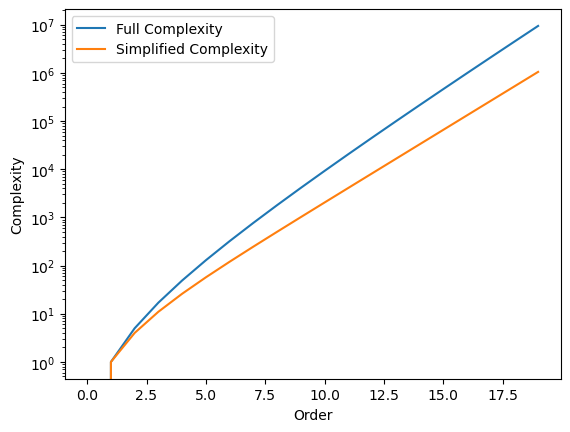

In [7]:
fig, ax = plt.subplots()
ax.plot(full, label='Full Complexity')
ax.plot(simp, label='Simplified Complexity')

# Log scale
ax.set_yscale('log')
ax.set_xlabel('Order')
ax.set_ylabel('Complexity')
ax.legend()
plt.show()

In [19]:
Spin = RDBasis("\\sigma", 'spin', dim=2)
sx = Spin.project(sp.Matrix([[0, 1], [1, 0]]))
sz = Spin.project(sp.Matrix([[1, 0], [0, -1]]))

a = RDBoson("a", subspace ="b")
ad = RDBoson("{a^\\dagger}", subspace ="b", is_annihilation=False)

hbar = RDsymbol("hbar", order = 0)
omega = RDsymbol("omega", order = 0)
Omega_z = RDsymbol("\\Omega_{z}", order = 0)
g = RDsymbol("g", order = 1)

H = hbar * omega * ad * a + hbar * Omega_z * sp.Rational(1,2) * sz - hbar * g * (a + ad) * sx
H

\Omega_{z}*hbar*\sigma_{3}/2 - g*hbar*(a + {a^\dagger})*\sigma_{1} + hbar*omega*{a^\dagger}*a

In [20]:
def solver(H, composite_basis, order=2, full_diagonal=True):

    #print("Solver for the following Hamiltonian:")
    #display(H)
    #print("Using the following composite basis: " + composite_basis.name)
    #print(f"Order: {order}")
    #print(f"Full Diagonal: {full_diagonal}")
    #print("\n\n")


    #print("Prearing the keys".center(200, "-"))

    from_list_to_key_lenght = lambda l: ('-'.join([str(i) for i in l]), len(l))

    list_keys_full = generate_keys(order)
    keys = rearrange_keys(list_keys_full)
    keys.pop()

    rational_factorial = [sp.Rational(1, sp.factorial(i)) for i in range(order + 1)]

    #print("|\tList".ljust(25) + "Keys".center(20) + "Length\t|".rjust(25))
    for i, key in enumerate(keys):
        k_str, l = from_list_to_key_lenght(key)
        print(f"|\t{i}".ljust(25) + f"{k_str}".center(20) + f"{l}\t|".rjust(25))

    #print("\n\n")

    #print("Solving the Hamiltonian".center(200, "-"))

    H_ordered = group_by_order(H)
    elementes_ordered = {str(key): value for key, value in H_ordered.items()}

    # Aling to the left the title and the values to the right
    
    #print('H_ordered')
    #display_dict(H_ordered)
    #print('elementes_ordered')
    #display_dict(elementes_ordered)

    #print("\n\n")


    H0 = elementes_ordered.get('0', 0)

    #print("Initial values".center(200, "-"))

    #display_dict({'H_0': H0})

    Vk_dict = {}
    Bk_dict = {}
    H_final = 0
    
    for key, value in H_ordered.items():
        Hk = group_by_diagonal(value)
        H_final += Hk.get(True, 0)
        Vk_dict[key] = Hk.get(False, 0)

    #display_dict({'H_final': H_final})
    #display_dict(Vk_dict)
    #display_dict(Bk_dict)

    S = {}

    #print("-".center(200, "-"))

    #print('\n\n')
    #print("Solving the Hamiltonian".center(200, "-"))

    for key in keys:
        k_total, l_total = from_list_to_key_lenght(key)
        order_it = np.sum(key)
        k_last, _ = from_list_to_key_lenght(key[:-1])
        k, _ = from_list_to_key_lenght([key[-1]])

        #print("\n\n")
        #print(f"{k_total}".center(200, "-"))
        #print(f"\nKey: {key}, l_total: {l_total}, order_it: {order_it}, k_last: {k_last}, k: {k}\n")

        if l_total == 1:
            #print("\t * l_total == 1 > " + k_total)
            continue
            
        if l_total == 2 and key[0] == 0:
            Vk = Vk_dict.get(order_it, 0)
            Bk = Bk_dict.get(order_it, 0)

            #print(f"Solving S_{k}")
            #display_dict({'V_k': Vk, 'B_k': Bk})

            Vk_plus_Bk = Vk + Bk

            if Vk_plus_Bk == 0:
                S[k] = 0
                print("-".center(200, "-"))
                continue

            Sk, symbols_s = get_ansatz(Vk_plus_Bk, composite_basis)
            #display_dict({'S_k': Sk})
            #display_dict({'Symbols': symbols_s})

            S_k_grouped = group_by_infinite_operators(Sk)
            #print("Sk grouped by infinite operators")
            #display_dict(S_k_grouped)
            S_k_solved = 0

            elementes_ordered[k_total] = - Vk_plus_Bk
            eq = expand_commutator(Commutator(H0, Sk) + Vk_plus_Bk).doit()
            #display_dict({'Equation to solve': eq})

            expression_to_solve = composite_basis.project(eq).simplify().expand()
            sols = {s : 0 for s in symbols_s}

            group_by_infinite_operators_dict = group_by_infinite_operators(expression_to_solve)
            for key, value in group_by_infinite_operators_dict.items():
                if value == 0:
                    continue
                solution_dict = RD_solve(value, symbols_s)
                sols.update(solution_dict)
                sk = S_k_grouped.get(key, 0)
                if sk == 0:
                    continue
                S_k_solved += key * sk.subs(sols)
            
            #print("S_k_solved")
            #display_dict(sols)
            #display_dict({f'S_{k}': S_k_solved})
            #print("-".center(200, "-"))
            S[k] = S_k_solved
            continue
        
        prev_term = elementes_ordered.get(k_last, 0)
        #display_dict({f'Previous term  {k_last}': prev_term})
        Sk = S[k]
        #display_dict({f"Factorial for {k_total}":rational_factorial[l_total - 1]})
        new_term =  composite_basis.project(expand_commutator(Commutator(prev_term, Sk)).doit()).simplify().expand()
        #display_dict({f'New term  {k_total}': new_term})

        print("-".center(200, "-"))

        elementes_ordered[k_total] = new_term

        new_term_to_the_hamiltonian = rational_factorial[l_total - 1] *new_term

        if not full_diagonal:
            H_final += new_term_to_the_hamiltonian
            continue

        Hk_new = group_by_diagonal(new_term_to_the_hamiltonian)
        Bk_dict[order_it] = Bk_dict.get(order_it, 0) + Hk_new.get(False, 0)
        H_final += Hk_new.get(True, 0)
        
    return H_final, S
   


In [21]:
sol = solver(H, Spin, order=3, full_diagonal=True)

|	0                               0                                1	|
|	1                               1                                1	|
|	2                              0-1                               2	|
|	3                             0-1-1                              3	|
|	4                              1-1                               2	|
|	5                               2                                1	|
|	6                              0-2                               2	|
|	7                            0-1-1-1                             4	|
|	8                             0-1-2                              3	|
|	9                             0-2-1                              3	|
|	10                            1-1-1                              3	|
|	11                             1-2                               2	|
|	12                             2-1                               2	|
|	13                              3                                1	|
------

In [22]:
comm_relations = {
    a*ad : ad * a + 1,
}

sol[0].expand().subs(comm_relations).expand()

2*\Omega_{z}*g**2*hbar*{a^\dagger}*a*\sigma_{3}/(\Omega_{z}**2 - omega**2) + \Omega_{z}*g**2*hbar*\sigma_{3}/(\Omega_{z}**2 - omega**2) + \Omega_{z}*hbar*\sigma_{3}/2 + g**2*hbar*omega/(\Omega_{z}**2 - omega**2) + hbar*omega*{a^\dagger}*a

In [23]:
sol[0]

2*\Omega_{z}*g**2*hbar*a*{a^\dagger}*\sigma_{3}/(\Omega_{z}**2 - omega**2) - \Omega_{z}*g**2*hbar*\sigma_{3}/(\Omega_{z}**2 - omega**2) + \Omega_{z}*hbar*\sigma_{3}/2 + g**2*hbar*omega/(\Omega_{z}**2 - omega**2) + hbar*omega*{a^\dagger}*a

In [24]:
s0, sx, sy, sz = Spin._basis
sigma_p = sp.Rational(1,2) * (sx + sp.I * sy)
sigma_m = sp.Rational(1,2) * (sx - sp.I * sy)
S1 = (g / (omega + Omega_z) * sigma_p + g/(omega - Omega_z) * sigma_m) * ad - (g / (omega - Omega_z) * sigma_p + g/(omega + Omega_z) * sigma_m) * a
S1.simplify().expand()

I*\Omega_{z}*g*\sigma_{2}*a/(\Omega_{z}**2 - omega**2) + I*\Omega_{z}*g*\sigma_{2}*{a^\dagger}/(\Omega_{z}**2 - omega**2) + g*omega*\sigma_{1}*a/(\Omega_{z}**2 - omega**2) - g*omega*\sigma_{1}*{a^\dagger}/(\Omega_{z}**2 - omega**2)

In [25]:
S2 = Omega_z * g**2 / (2 * omega * (omega**2 - Omega_z**2)) * (ad * ad - a * a) * sz

S2.simplify().expand()

\Omega_{z}*g**2*a**2*\sigma_{3}/(2*\Omega_{z}**2*omega - 2*omega**3) - \Omega_{z}*g**2*{a^\dagger}**2*\sigma_{3}/(2*\Omega_{z}**2*omega - 2*omega**3)

# Comparison with PymaBlock

In [26]:
wr = RDsymbol("\\omega_{r}", order = 0)
wq = RDsymbol("\\omega_{q}", order = 0)
g = RDsymbol("g", order = 1)

Spin = RDBasis("\\sigma", 'spin', dim=2)
s0, sx, sy, sz = Spin._basis

sigma_p = sp.Rational(1,2)* (sx + sp.I * sy)
sigma_m = sp.Rational(1,2)* (sx - sp.I * sy)

a = RDBoson("a", subspace ="resonator")
ad = RDBoson("{a^\\dagger}", subspace ="resonator", is_annihilation=False)

H0 = wr * ad * a - wq * sp.Rational(1,2) * sz
H = H0 + g * a* sigma_m + g * ad * sigma_p
H

-\omega_{q}*\sigma_{3}/2 + \omega_{r}*{a^\dagger}*a + g*a*(\sigma_{1} - I*\sigma_{2})/2 + g*{a^\dagger}*(\sigma_{1} + I*\sigma_{2})/2

In [27]:
H_perturbation_order = (solver(H, Spin, order=6, full_diagonal=False)[0]).expand()

|	0                               0                                1	|
|	1                               1                                1	|
|	2                              0-1                               2	|
|	3                             0-1-1                              3	|
|	4                              1-1                               2	|
|	5                               2                                1	|
|	6                              0-2                               2	|
|	7                            0-1-1-1                             4	|
|	8                             0-1-2                              3	|
|	9                             0-2-1                              3	|
|	10                            1-1-1                              3	|
|	11                             1-2                               2	|
|	12                             2-1                               2	|
|	13                              3                                1	|
|	14  

In [28]:
def subs_dict(expr, dictionary):
    expanded = expr.expand()
    while expanded != expanded.subs(dictionary):
        expanded = expanded.subs(dictionary).expand()
    return expanded

In [29]:
n = RDBoson('n', subspace='resonator', is_annihilation=False)
comm_relations = {
    a*ad : ad * a + 1,
    ad * a : n,
    a * n : n * a + a,
    ad * n : n * ad - ad,
}
result_mat = sp.zeros(2)
for k, val in group_by_finite_operators(subs_dict(H_perturbation_order, comm_relations).expand()).items():
    if k == 1:
        mat = sp.eye(2)
    else:
        mat = get_matrix(k)
    result_mat += val * mat

#result_mat = sp.simplify(result_mat).expand()
display(result_mat)
ordered_dict = group_by_order(result_mat[0, 0])
result_simp_dict = {}
for k, v in ordered_dict.items():
    result_simp_dict[k] = v.simplify().expand()
display_dict(result_simp_dict)

Matrix([
[-\omega_{q}/2 + \omega_{r}*n + 8*g**6*n/(36*\omega_{q}**5 - 180*\omega_{q}**4*\omega_{r} + 360*\omega_{q}**3*\omega_{r}**2 - 360*\omega_{q}**2*\omega_{r}**3 + 180*\omega_{q}*\omega_{r}**4 - 36*\omega_{r}**5) + 9*g**6*n**2/(36*\omega_{q}**5 - 180*\omega_{q}**4*\omega_{r} + 360*\omega_{q}**3*\omega_{r}**2 - 360*\omega_{q}**2*\omega_{r}**3 + 180*\omega_{q}*\omega_{r}**4 - 36*\omega_{r}**5) - 4*g**6/(18*\omega_{q}**5 - 90*\omega_{q}**4*\omega_{r} + 180*\omega_{q}**3*\omega_{r}**2 - 180*\omega_{q}**2*\omega_{r}**3 + 90*\omega_{q}*\omega_{r}**4 - 18*\omega_{r}**5) - 10*g**6*n/(18*\omega_{q}**5 - 90*\omega_{q}**4*\omega_{r} + 180*\omega_{q}**3*\omega_{r}**2 - 180*\omega_{q}**2*\omega_{r}**3 + 90*\omega_{q}*\omega_{r}**4 - 18*\omega_{r}**5) - 8*g**6*n**2/(18*\omega_{q}**5 - 90*\omega_{q}**4*\omega_{r} + 180*\omega_{q}**3*\omega_{r}**2 - 180*\omega_{q}**2*\omega_{r}**3 + 90*\omega_{q}*\omega_{r}**4 - 18*\omega_{r}**5) - 4*g**6*n**3/(18*\omega_{q}**5 - 90*\omega_{q}**4*\omega_{r} + 180

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Transmon Qubit coupled to resonator

In [105]:
at = RDBoson("{a_t}", subspace ="transmon")
adt = RDBoson("{a_t^\\dagger}", subspace ="transmon", is_annihilation=False)

ar = RDBoson("{a_r}", subspace ="resonator")
adr = RDBoson("{a_r^\\dagger}", subspace ="resonator", is_annihilation=False)

omega_t = RDsymbol("\\omega_{t}", order = 0)
omega_r = RDsymbol("\\omega_{r}", order = 0)
alpha = RDsymbol("\\alpha", order = 0)
g = RDsymbol("g", order = 1)

H0 =  -omega_t * ( adt * at  - sp.Rational(1,2) ) + sp.Rational(1,2) * alpha *adt*adt*at*at + omega_r * (adr *ar + sp.Rational(1,2))
H = H0 - g * (adt  - at) * (adr - ar)
H

\alpha*{a_t^\dagger}**2*{a_t}**2/2 + \omega_{r}*(1/2 + {a_r^\dagger}*{a_r}) - \omega_{t}*(-1/2 + {a_t^\dagger}*{a_t}) - g*({a_t^\dagger} - {a_t})*({a_r^\dagger} - {a_r})

In [106]:
sol, S = solver(H, Spin, order=2, full_diagonal=False)

|	0                               0                                1	|
|	1                               1                                1	|
|	2                              0-1                               2	|
|	3                             0-1-1                              3	|
|	4                              1-1                               2	|
|	5                               2                                1	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [107]:
display_dict(S)

<IPython.core.display.Math object>

In [108]:
subs = {
    at * adt : adt * at + 1,
    ar * adr : adr * ar + 1,
}
subs_to_zero = {
    at : 0,
    adt : 0,
    ar : 0,
    adr : 0,
}
(sol - H0).subs(subs).expand().subs(subs_to_zero).expand().simplify().expand()

g**2/(2*\omega_{t}) - g**2/(2*\omega_{r})

In [113]:
display_dict(group_by_diagonal(H0))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [111]:
display_dict(group_by_infinite_operators((sol - H0).subs(subs).expand()))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [83]:
for v in (sol - H0).as_ordered_terms():
    display(v.expand())

-\omega_{r}**2*g**2*{a_r^\dagger}*{a_r}/(\omega_{r}**2*\omega_{t} - \omega_{r}*\omega_{t}**2)

\omega_{r}**2*g**2*{a_r^\dagger}**2/(\omega_{r}**2*\omega_{t} - \omega_{r}*\omega_{t}**2)

\omega_{r}**2*g**2*{a_t^\dagger}**2/(\omega_{r}**2*\omega_{t} - \omega_{r}*\omega_{t}**2)

-\omega_{r}**2*g**2*{a_t}*{a_t^\dagger}/(\omega_{r}**2*\omega_{t} - \omega_{r}*\omega_{t}**2)

\omega_{r}*\omega_{t}*g**2*{a_r^\dagger}*{a_r}/(\omega_{r}**2*\omega_{t} - \omega_{r}*\omega_{t}**2)

-\omega_{r}*\omega_{t}*g**2*{a_r^\dagger}**2/(\omega_{r}**2*\omega_{t} - \omega_{r}*\omega_{t}**2)

-\omega_{r}*\omega_{t}*g**2*{a_t^\dagger}*{a_t}/(\omega_{r}**2*\omega_{t} - \omega_{r}*\omega_{t}**2)

\omega_{r}*\omega_{t}*g**2*{a_t}**2/(\omega_{r}**2*\omega_{t} - \omega_{r}*\omega_{t}**2)

\omega_{r}/2

\omega_{r}*{a_r^\dagger}*{a_r}

\omega_{t}**2*g**2*{a_r}*{a_r^\dagger}/(\omega_{r}**2*\omega_{t} - \omega_{r}*\omega_{t}**2)

-\omega_{t}**2*g**2*{a_r}**2/(\omega_{r}**2*\omega_{t} - \omega_{r}*\omega_{t}**2)

\omega_{t}**2*g**2*{a_t^\dagger}*{a_t}/(\omega_{r}**2*\omega_{t} - \omega_{r}*\omega_{t}**2)

-\omega_{t}**2*g**2*{a_t}**2/(\omega_{r}**2*\omega_{t} - \omega_{r}*\omega_{t}**2)

\omega_{t}/2

\omega_{t}*{a_t^\dagger}*{a_t}

-\alpha*{a_t^\dagger}**2*{a_t}**2/2 - \omega_{r}/2 - \omega_{r}*{a_r^\dagger}*{a_r} - \omega_{t}/2 - \omega_{t}*{a_t^\dagger}*{a_t}

\omega_{r}**2*g**2*{a_r^\dagger}*{a_r}/(2*\omega_{r}**2*\omega_{t} - 2*\omega_{r}*\omega_{t}**2) - \omega_{r}**2*g**2*{a_r^\dagger}**2/(2*\omega_{r}**2*\omega_{t} - 2*\omega_{r}*\omega_{t}**2) - \omega_{r}**2*g**2*{a_t^\dagger}**2/(2*\omega_{r}**2*\omega_{t} - 2*\omega_{r}*\omega_{t}**2) + \omega_{r}**2*g**2*{a_t}*{a_t^\dagger}/(2*\omega_{r}**2*\omega_{t} - 2*\omega_{r}*\omega_{t}**2) - \omega_{r}*\omega_{t}*g**2*{a_r^\dagger}*{a_r}/(2*\omega_{r}**2*\omega_{t} - 2*\omega_{r}*\omega_{t}**2) + \omega_{r}*\omega_{t}*g**2*{a_r^\dagger}**2/(2*\omega_{r}**2*\omega_{t} - 2*\omega_{r}*\omega_{t}**2) + \omega_{r}*\omega_{t}*g**2*{a_t^\dagger}*{a_t}/(2*\omega_{r}**2*\omega_{t} - 2*\omega_{r}*\omega_{t}**2) - \omega_{r}*\omega_{t}*g**2*{a_t}**2/(2*\omega_{r}**2*\omega_{t} - 2*\omega_{r}*\omega_{t}**2) - \omega_{t}**2*g**2*{a_r}*{a_r^\dagger}/(2*\omega_{r}**2*\omega_{t} - 2*\omega_{r}*\omega_{t}**2) + \omega_{t}**2*g**2*{a_r}**2/(2*\omega_{r}**2*\omega_{t} - 2*\omega_{r}*\omega_{t}**2) - \omega_{t